<a href="https://colab.research.google.com/github/analystanand/Machine-Learning/blob/master/Card_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capital One Data Science Challenge

### Dowload and Extract Data

In [0]:
# !git clone https://github.com/CapitalOneRecruiting/DS.git
# !unzip DS/transactions.zip

##Library Installations

In [0]:
# !pip install jsonlines
# !pip install pandas

In [0]:
%matplotlib inline
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
import jsonlines
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

#Question 1: Load

Read transactions from file and Load into panda dataFrame

In [0]:
FILENAME= "./transactions.txt"
transactions = []
with jsonlines.open(FILENAME) as file:
    transactions = [record for record in file]
transactions_df = pd.DataFrame(transactions)

In [148]:
print("Number of transaction records",transactions_df.shape[0])
print("No. of Customers",transactions_df.customerId.unique().shape[0])

Number of transaction records 786363
No. of Customers 5000


In [149]:
transactions_df.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


### There are few empty columns and are not useful for analysis  and it good to drop them.

In [150]:
empty_columns = []
for i in transactions_df.columns.values:
  if len(set(transactions_df[i]))==1:
     empty_columns.append(i)

transactions_df = transactions_df.drop(empty_columns,axis=1)
transactions_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [0]:
transactions_df['transaction_id'] = transactions_df.index #for uniquely identifying record

In [152]:
transactions_df.dtypes

accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
currentBalance              float64
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
transaction_id                int64
dtype: object

In [153]:
transactions_df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance,transaction_id
count,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089,393181.000000
std,11636.174890,8880.783989,147.725569,6457.442068,227003.589202
min,250.000000,-1005.630000,0.000000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000,196590.500000
50%,7500.000000,3184.860000,87.900000,2451.760000,393181.000000
75%,15000.000000,7500.000000,191.480000,5291.095000,589771.500000
max,50000.000000,50000.000000,2011.540000,47498.810000,786362.000000


#Question 2: Plot

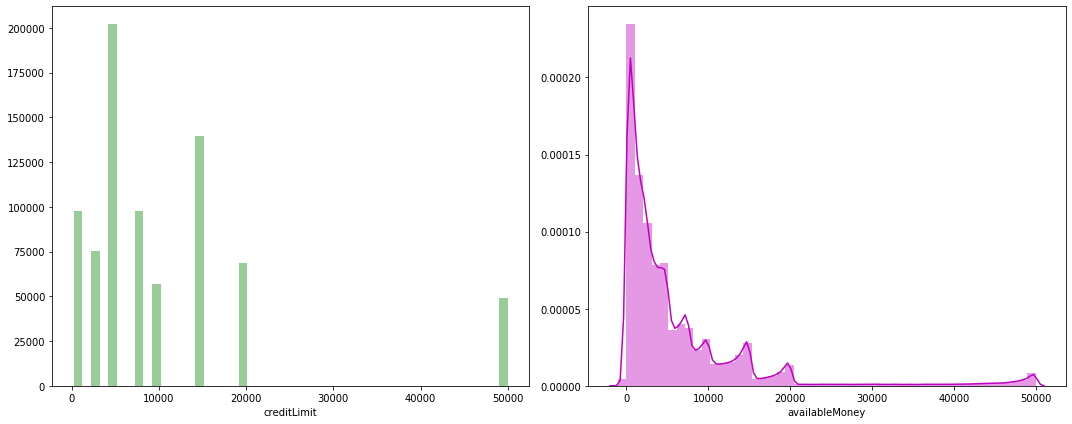

In [265]:
#reference:https://seaborn.pydata.org/examples/distplot_options.html
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.distplot(transactions_df['creditLimit'],kde=False, color="g", ax=axes[0])
sns.distplot(transactions_df['availableMoney'],kde=True,color="m", ax=axes[1])
plt.tight_layout()
plt.show()

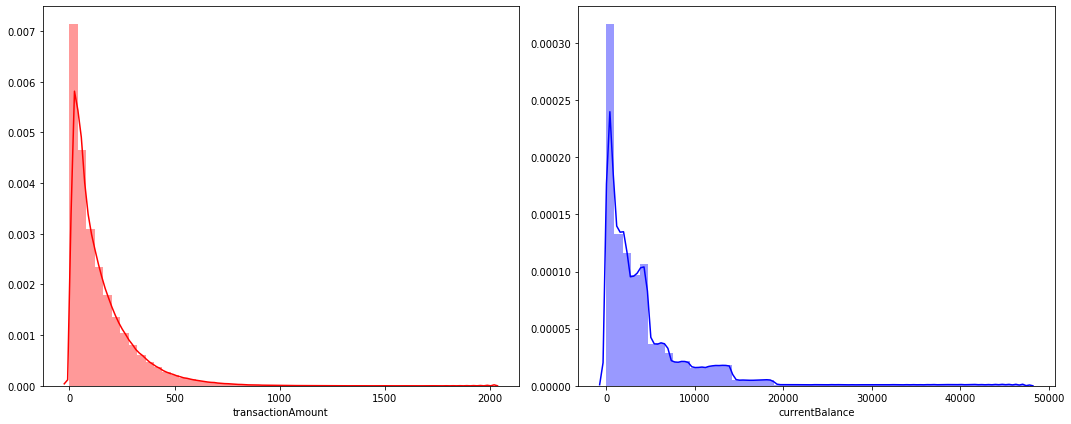

In [271]:
#reference:https://seaborn.pydata.org/examples/distplot_options.html
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.distplot(transactions_df['transactionAmount'],kde=True,norm_hist=True, color="r", ax=axes[0])
sns.distplot(transactions_df['currentBalance'],kde=True,norm_hist=True,color="b", ax=axes[1])
plt.tight_layout()
plt.show()

#Question 3: Data Wrangling - Duplicate Transactions

In [0]:
transaction_with_dup_flag = transactions_df[["customerId","transactionAmount","merchantName"]].duplicated()

In [0]:
transactions_df["isDuplicate"]=transaction_with_dup_flag

In [0]:
duplicate_transactions = transactions_df[transactions_df["isDuplicate"]==True]

In [0]:
result =  duplicate_transactions[["customerId","transactionAmount","merchantName","transactionDateTime"]].groupby(by=["customerId","transactionAmount","merchantName"]).count()

In [0]:
dup_analysis_df = result.reset_index()

In [0]:
dup_analysis_df = dup_analysis_df.rename(columns={"transactionDateTime": "occurence"})

In [0]:
dup_analysis_df['dup_category'] = np.where(dup_analysis_df['occurence']>1, 'multi-swipe', 'reversed')

In [224]:
analysis = dup_analysis_df.groupby(by=["dup_category"]).sum()
analysis.head()

,transactionAmount,occurence
dup_category,,
multi-swipe,272232.43,47451
reversed,3674589.58,27696


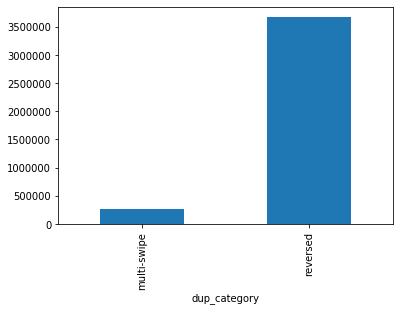

In [225]:
analysis["transactionAmount"].plot.bar()
plt.show()

# Question 4: Model

## Distribution of Fraud and Regular Case

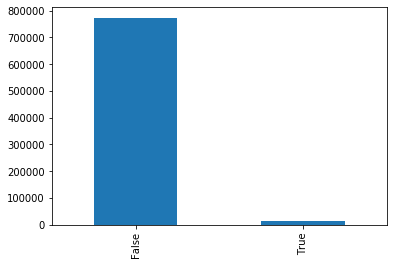

In [165]:
class_dist=pd.value_counts(transactions_df["isFraud"], sort= True)
class_dist.plot(kind= 'bar')
plt.show()

In [166]:
No_of_Normal_transacation = len(transactions_df[transactions_df["isFraud"]==True]) 
No_of_Fraud_transacation =len(transactions_df[transactions_df["isFraud"]==False])
percent_of_fraud_transaction =  No_of_Fraud_transacation/(No_of_Normal_transacation+No_of_Fraud_transacation)
percent_of_normal_transaction = No_of_Normal_transacation/(No_of_Normal_transacation+No_of_Fraud_transacation)
print("percent of Normal transactions: {0:.2%}".format(percent_of_fraud_transaction))
print("percent of Fraud transactions: {0:.2%}".format(percent_of_normal_transaction))


percent of Normal transactions: 98.42%
percent of Fraud transactions: 1.58%


As we can see that fraud transactions are just 1.58% of total transactions. This is highly imbalanced dataset so we have to carefully choose metric for performance evaluation as well as train a model which is not baised towards normal transaction.For example: randomly predicting all transaction as normal will provide high accuracy to the model but it's not useful for us. 


---
There are popular three techniques to handle imbalanced data.
1. undersampling the majority class
2. oversampling the minority class
3. Weight based loss function to penalize model when it observe minority class

We will try only undersampling method although we will lose information but to train a model without an inherent bias towards majority class.

First of all lets seperate the data into training and test set before undersampling this is real scenarios we will be facing when it comes to deployment.

Feature Exploration: Let's check how data is distributed among normal and fraud transactions

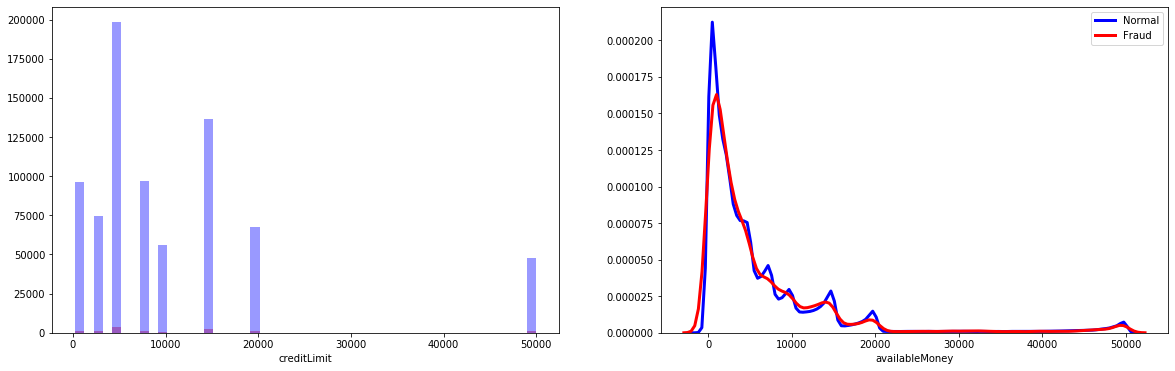

In [274]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=False)
sns.distplot(transactions_df[transactions_df['isFraud']==True]["creditLimit"],hist=True,kde=False,color="r",label='Fraud',ax=axes[0])
sns.distplot(transactions_df[transactions_df['isFraud']==False]['creditLimit'],hist=True,kde=False,color="b",label='Normal',ax=axes[0])
sns.distplot(transactions_df[transactions_df['isFraud']==False]['availableMoney'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(transactions_df[transactions_df['isFraud']==True]["availableMoney"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

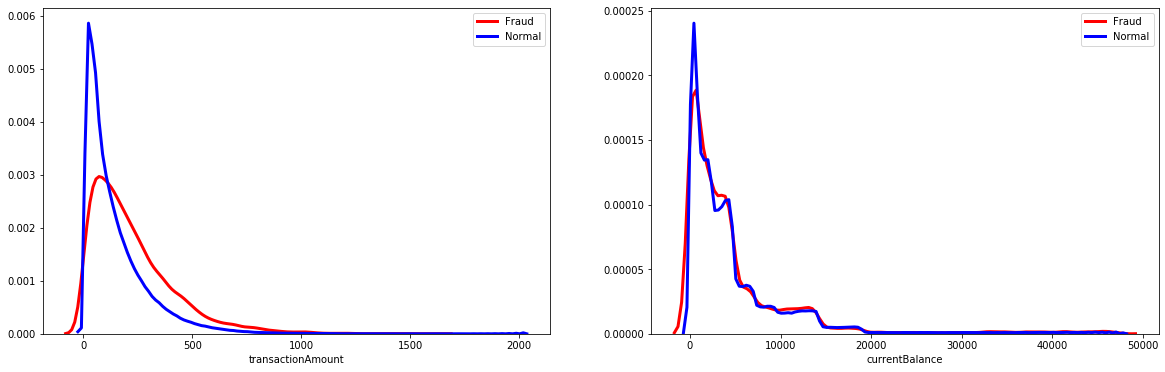

In [275]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=False)
sns.distplot(transactions_df[transactions_df['isFraud']==True]["transactionAmount"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(transactions_df[transactions_df['isFraud']==False]['transactionAmount'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(transactions_df[transactions_df['isFraud']==True]["currentBalance"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(transactions_df[transactions_df['isFraud']==False]['currentBalance'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

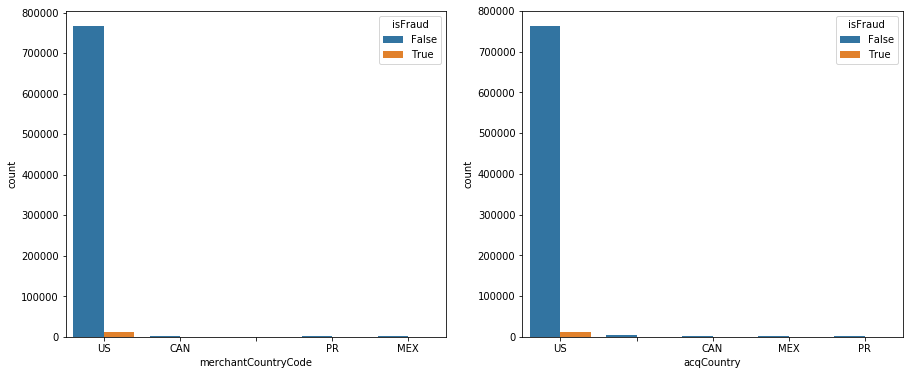

In [276]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('merchantCountryCode', data = transactions_df,hue="isFraud",ax=axes[0])
sns.countplot('acqCountry', data = transactions_df,hue="isFraud",ax=axes[1])
plt.show()

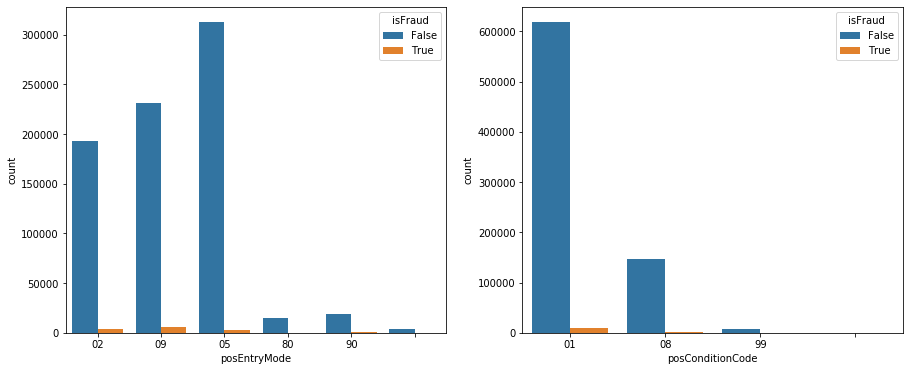

In [260]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('posEntryMode', data = transactions_df,hue="isFraud",ax=axes[0])
sns.countplot('posConditionCode', data = transactions_df,hue="isFraud",ax=axes[1])
plt.show()

Merchant Category could be interesting to explore as to see its distribution over normal and fraud transaction

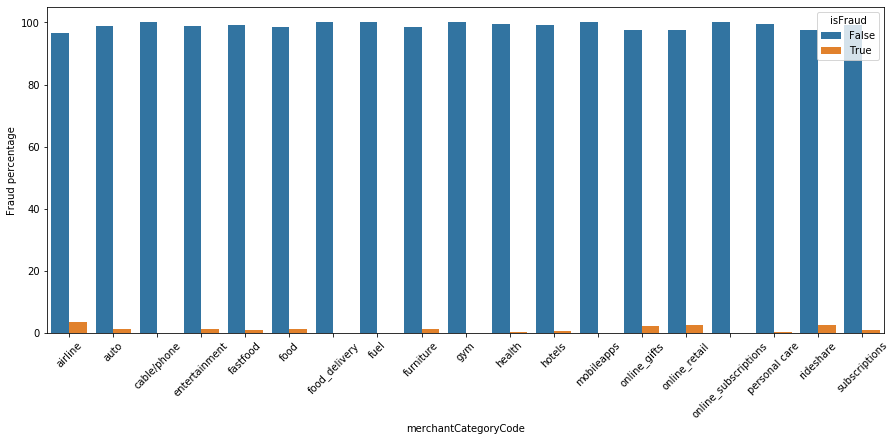

In [262]:
grp_by_merc_code = transactions_df.groupby(by=["merchantCategoryCode","isFraud"])["accountNumber"].count().reset_index()
grp_by_merc_code['Fraud percentage'] = grp_by_merc_code["accountNumber"]*100 / grp_by_merc_code.groupby("merchantCategoryCode")["accountNumber"].transform("sum")
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)
sns.barplot('merchantCategoryCode', 'Fraud percentage',hue = 'isFraud', data = grp_by_merc_code)
plt.show()

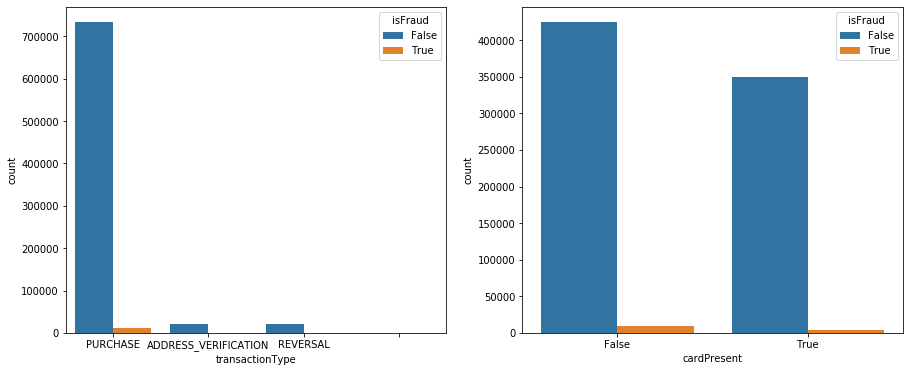

In [295]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('transactionType', data = transactions_df,hue="isFraud",ax=axes[0])
sns.countplot('cardPresent', data = transactions_df,hue="isFraud",ax=axes[1])
plt.show()

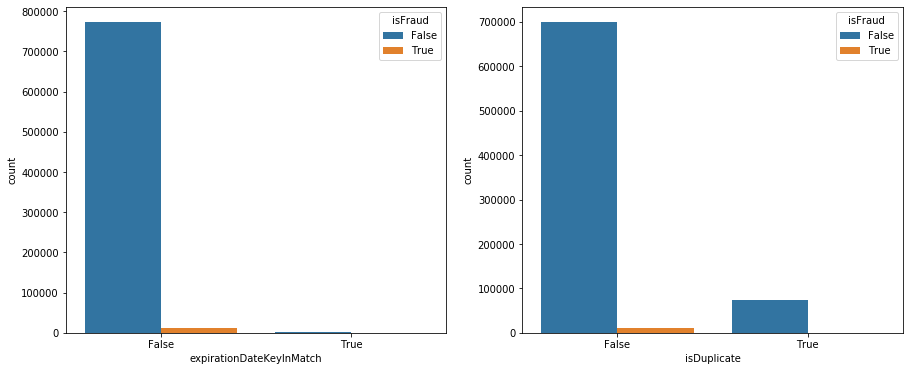

In [306]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('expirationDateKeyInMatch', data = transactions_df,hue="isFraud",ax=axes[0])
sns.countplot('isDuplicate', data = transactions_df,hue="isFraud",ax=axes[1])
plt.show()

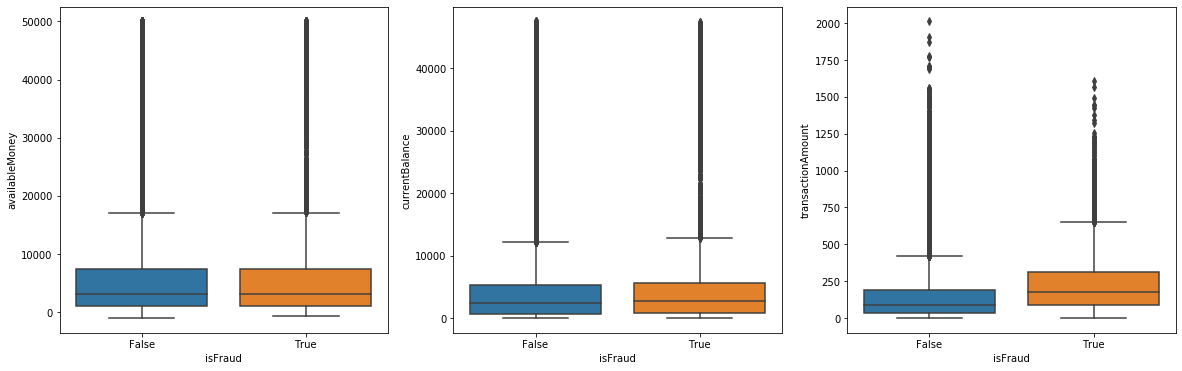

In [297]:
f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=True)
ax = sns.boxplot(x="isFraud", y="availableMoney", data=transactions_df,ax =axes[0])
ax = sns.boxplot(x="isFraud", y="transactionAmount", data=transactions_df,ax =axes[2])
ax = sns.boxplot(x="isFraud", y="currentBalance", data=transactions_df,ax =axes[1])

Finding out if there is any relation between fraudulent transaction w.r.t date of last address change

In [0]:
transactions_df["transactionDateTime"] = pd.to_datetime(transactions_df["transactionDateTime"])

In [0]:
transactions_df["dateOfLastAddressChange"] = pd.to_datetime(transactions_df["dateOfLastAddressChange"])
transactions_df['diff_address_transactions'] = transactions_df['transactionDateTime'] - transactions_df['dateOfLastAddressChange']
transactions_df['diff_address_transactions'] = transactions_df['diff_address_transactions']/np.timedelta64(1,'D')

Finding out if there is any relation between fraudulent transaction w.r.t date of account open date

In [0]:
transactions_df["accountOpenDate"] = pd.to_datetime(transactions_df["accountOpenDate"])
transactions_df['diff_accountopen_transactions'] = transactions_df['transactionDateTime'] - transactions_df['accountOpenDate']
transactions_df['diff_accountopen_transactions'] = transactions_df['diff_accountopen_transactions']/np.timedelta64(1,'D')

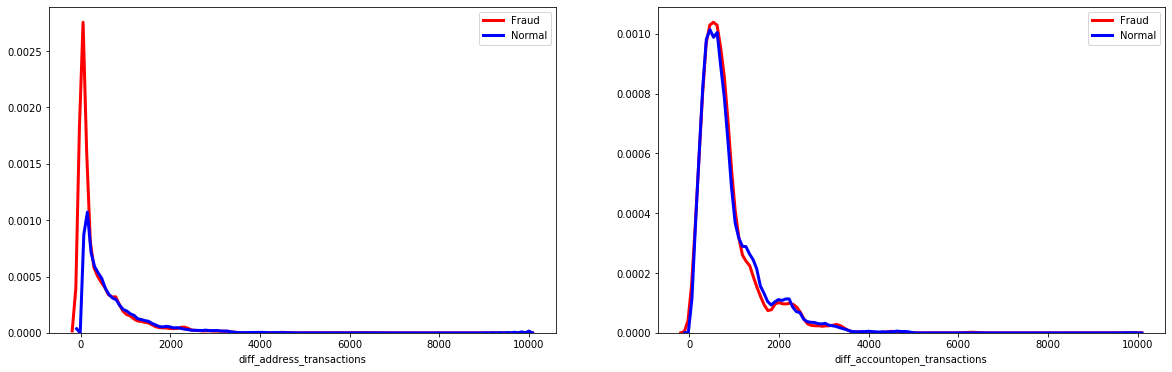

In [294]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=True)
sns.distplot(transactions_df[transactions_df['isFraud']==True]["diff_address_transactions"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(transactions_df[transactions_df['isFraud']==False]['diff_address_transactions'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(transactions_df[transactions_df['isFraud']==True]["diff_accountopen_transactions"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(transactions_df[transactions_df['isFraud']==False]['diff_accountopen_transactions'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

After analyzing distribution of dateOfLastAddressChange and accountOpenDate w.r.t transactionDate, we can say that more number of fraudulent transaction have recently changed address where account opening date has little co-relation with fraudulent transactions.


In [307]:
transactions_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_id,isDuplicate,diff_address_transactions,diff_accountopen_transactions,diff_cvv
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,0,False,518.602454,518.602454,True
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,1,False,577.212431,577.212431,True
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,2,False,605.387951,605.387951,True
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,3,True,637.093634,637.093634,True
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,4,False,231.878310,231.878310,True
